# Hardware-Efficient Simulation of Energy Transfer Dynamics

Yuan Liu, 10/21/2022

In [1]:
# Set up the matplotlib graphics library and configure it to show figures inline in the notebook
%matplotlib inline
import matplotlib.pyplot as plt

# Necessary mathematical libraries
import numpy as np
from numpy import pi, sqrt
import pandas as pd

# Exact Quantum Simulator
from qutip import *


## Hamiltonian
See the overleaf document for the exact Hamiltonian.

### Problem parameters


For this simulation, we will be setting planck's constant, $\hbar = 1$, and $cm^{-1}$ will be used as the frequency unit.

In [2]:
# Parameters in the 3-chromophore model, mostly obtained from a previous dimer model.
omega_ga = 4.95e13
omega_ea = 4.63e13
omega_gb = 4.98e13
omega_eb = 4.62e13
omega_gc = 4.92e13
omega_ec = 4.65e13
omega_l = 6.00e12
J_AB_0 = 3.00e12
J_AC_0 = 2.70e12
eta_AB = -0.1
eta_AC = 0.15
S_a = 0.005
S_b = 0.004
S_c = 0.006
S_l = 0.05 # tunable, 0.0 - 0.1
gamma_A = 3.15e12
gamma_B = 3.15e12
gamma_C = 3.15e12

# Conversion of 3-chromophore parameters to parameters in the Hamiltonian
omega_a = (omega_ga + omega_ea)/2
omega_b = (omega_gb + omega_eb)/2
omega_c = (omega_gc + omega_ec)/2
omega_l = omega_l
chi_a = omega_ea - omega_ga
chi_b = omega_eb - omega_gb
chi_c = omega_ec - omega_gc
omega_qa = 2 * (S_a * omega_ea + S_l * omega_l) + (chi_a) / 2
omega_qb = 2 * S_b * omega_eb + (chi_b) / 2
omega_qc = 2 * S_c * omega_ec + (chi_c) / 2
g_cd_a = np.sqrt(2 * S_a) * omega_ea
g_cd_b = np.sqrt(2 * S_b) * omega_eb
g_cd_c = np.sqrt(2 * S_c) * omega_ec
g_cd_l = np.sqrt(2 * S_l) * omega_l
g_ab = J_AB_0
g_ac = J_AC_0
g_abl = g_ab * eta_AB
g_acl = g_ac * eta_AC
g_a = g_cd_a / 2
g_b = g_cd_b / 2
g_c = g_cd_c / 2
g_l = g_cd_l / 2
delta_ab = omega_qa - omega_qb
delta_ac = omega_qa - omega_qc



N = 4             # truncation level for the high frequency modes
Nl = N*2           # truncation level for the low frequency mode

timelist = np.linspace(0,2e-12,200) # The timeframe + steps for the exact simulation

### Setup the operators, the Hamiltonian and initial state

In [3]:
# Initial state, tensor product of three 2-level system and four bosonic modes.
# The last bosonic mode being the low frequency mode l. From left to right are A, B, C
psi0 = tensor(basis([2,2,2],[1,0,0]), basis([N,N,N,Nl],[0,0,0,0]))  # Start with an excited molecule A, and the rest in ground state


# identity operators
Id_qub = tensor(qeye(2), qeye(2), qeye(2))
Id_bos = tensor(qeye(N), qeye(N), qeye(N), qeye(Nl))

# projected bosonic mode operators
a_osc = tensor(destroy(N), qeye(N), qeye(N), qeye(Nl))
b_osc = tensor(qeye(N), destroy(N), qeye(N), qeye(Nl))
c_osc = tensor(qeye(N), qeye(N), destroy(N), qeye(Nl))
l_osc = tensor(qeye(N), qeye(N), qeye(N), destroy(Nl))
a  = tensor(Id_qub, a_osc)
b  = tensor(Id_qub, b_osc)
c  = tensor(Id_qub, c_osc)
l  = tensor(Id_qub, l_osc)

## Qubit operators
smA = tensor(destroy(2), qeye(2), qeye(2))
smB = tensor(qeye(2), destroy(2), qeye(2))
smC = tensor(qeye(2), qeye(2), destroy(2))
# Pauli X,Y, and Z gates on every qubit
sigma_xa_qub = tensor(sigmax(), qeye(2), qeye(2))
sigma_xb_qub = tensor(qeye(2), sigmax(), qeye(2))
sigma_xc_qub = tensor(qeye(2), qeye(2), sigmax())
sigma_ya_qub = tensor(sigmay(), qeye(2), qeye(2))
sigma_yb_qub = tensor(qeye(2), sigmay(), qeye(2))
sigma_yc_qub = tensor(qeye(2), qeye(2), sigmay())
sigma_za_qub = tensor(sigmaz(), qeye(2), qeye(2))
sigma_zb_qub = tensor(qeye(2), sigmaz(), qeye(2))
sigma_zc_qub = tensor(qeye(2), qeye(2), sigmaz())
# Extension of previous pauli gates to the full hilbert space
sigma_xa = tensor(sigma_xa_qub, Id_bos)
sigma_xb = tensor(sigma_xb_qub, Id_bos)
sigma_xc = tensor(sigma_xc_qub, Id_bos)
sigma_ya = tensor(sigma_ya_qub, Id_bos)
sigma_yb = tensor(sigma_yb_qub, Id_bos)
sigma_yc = tensor(sigma_yc_qub, Id_bos)
sigma_za = tensor(sigma_za_qub, Id_bos)
sigma_zb = tensor(sigma_zb_qub, Id_bos)
sigma_zc = tensor(sigma_zc_qub, Id_bos)
fullhadamard = tensor(core.gates.hadamard_transform(3), Id_bos)
sdag = tensor(core.gates.s_gate().dag(), core.gates.s_gate().dag(), core.gates.s_gate().dag())
fullsdag = tensor(sdag, Id_bos)



# qubit states
GroundState = basis([2,2,2],[0,0,0])
eA = basis([2,2,2],[1,0,0])
eB = basis([2,2,2],[0,1,0])
eC = basis([2,2,2],[0,0,1])


# Bosonic Hamiltonians
H0 = (omega_a * a.dag() * a) + (omega_b * b.dag() * b) + (omega_c * c.dag() * c) + (omega_l * l.dag() * l) - (delta_ab * sigma_zb / 2) - (delta_ac * sigma_zc / 2)

H1 = -(chi_a * a.dag() * a * sigma_za / 2) - (chi_b * b.dag() * b * sigma_zb / 2) - (chi_c * c.dag() * c * sigma_zc / 2)
H1 = H1 - (g_cd_a * (a + a.dag()) * sigma_za / 2) - (g_cd_b * (b + b.dag()) * sigma_zb / 2) - (g_cd_c * (c + c.dag()) * sigma_zc / 2)

H2XXGcdl = -(g_cd_l * (l + l.dag()) * sigma_za / 4)
H2XXRXX = (g_ab * (sigma_xa * sigma_xb) / 2) + (g_ac * (sigma_xa * sigma_xc) / 2) 
H2XXGabl = (g_abl * (sigma_xa * sigma_xb) * (l + l.dag()) / 2) + (g_acl * (sigma_xa * sigma_xc) * (l + l.dag()) / 2)
H2XX = H2XXGcdl + H2XXRXX + H2XXGabl

H2YYGcdl = -(g_cd_l * (l + l.dag()) * sigma_za / 4)
H2YYRXX = (g_ab * (sigma_ya * sigma_yb) / 2) + (g_ac * (sigma_ya * sigma_yc) / 2) 
H2YYGabl = (g_abl * (sigma_ya * sigma_yb) * (l + l.dag()) / 2) + (g_acl * (sigma_ya * sigma_yc) * (l + l.dag()) / 2)
H2YY = H2YYGcdl + H2YYRXX + H2YYGabl

# Total Hamiltonian (without  dissipation)
Htot = (H0 + H1 + H2XX + H2YY)

### Evolve the system

Here we evolve the system with the Lindblad master equation solver or the Monte Carlo solver, and we request that the expectation values of the operators $a^\dagger a$ and $\sigma_{+,A}\sigma_{-,A}$ are returned by the solver.

In [4]:
# Monte Carlo Solver
#ntraj = [1, 5, 15, 904] # list of number of trajectories to avg. over
#ntraj = [1] # list of number of trajectories to avg. over
#output = mcsolve(Htot, psi0, tlist, c_ops, [tensor(Id_qub, a.dag() * a), tensor(smA.dag() * smA, Id_bos)], ntraj)

# Lindblad Master Equation Solver
c_ops = []
output = mesolve(Htot, psi0, timelist, c_ops, [tensor(Id_qub, a_osc.dag() * a_osc), tensor(Id_qub, b_osc.dag() * b_osc), 
                                         tensor(Id_qub, c_osc.dag() * c_osc), tensor(Id_qub, l_osc.dag() * l_osc), 
                                         tensor(smA.dag() * smA, Id_bos), 
                                         tensor(smB.dag() * smB, Id_bos), 
                                         tensor(smC.dag() * smC, Id_bos)],
                 options=Options(nsteps=30000))

C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


## Visualize the results

Here we plot the excitation probabilities of the mode and the qubit (these expectation values were calculated by the `mesolve` above).

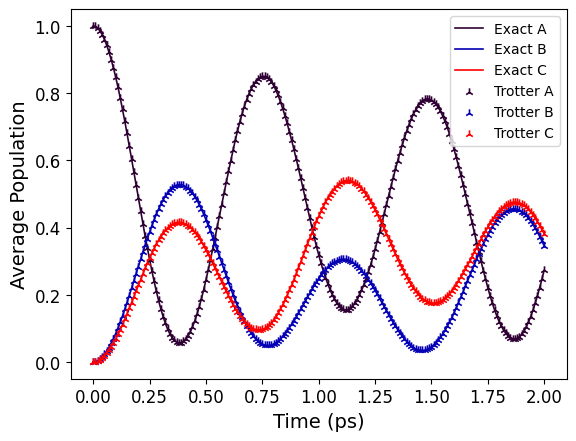

In [ ]:
# Collect Exact simulation Data
n_a = output.expect[0]
n_b = output.expect[1]
n_c = output.expect[2]
n_l = output.expect[3]
n_A = output.expect[4]
n_B = output.expect[5]
n_C = output.expect[6]

fig, axes = plt.subplots(1, 1)

# Scale time to be in terms of picoseconds and plotting of exact simulation results
timelist = timelist * 1e12
axes.plot(timelist, n_A, label="Exact A", linewidth=1.2, color='#2f0033')
axes.plot(timelist, n_B, label="Exact B", linewidth=1.2, color='#0500b4')
axes.plot(timelist, n_C, label="Exact C", linewidth=1.2, color='#ff0000')

# Read in and plot data file to compare against exact simulation
data_file = 'data/general/nodamping.out'
df = pd.read_csv(data_file, delimiter='\s*\(|[\+-]\d\.\d+e[\+-]\d+j\) *\(|[\+-]\d\.\d+e[\+-]\d+j\)', engine = 'python')
df.drop(columns=df.columns[0], axis=1, inplace=True)
df.drop(columns=df.columns[len(df.columns)-1], axis=1, inplace=True)
df.columns = df.columns.map(float)
data = df.to_numpy()
columns = df.columns.to_numpy()
columns = columns
marker = '2'
#axes.scatter(columns, data[0], marker=marker, label="Trotter A", linewidth=1.2, color='#2f0033', zorder=2.5)
#axes.scatter(columns, data[1], marker=marker, label="Trotter B", linewidth=1.2, color='#0500b4', zorder=2.5)
#axes.scatter(columns, data[2], marker=marker, label="Trotter C", linewidth=1.2, color='#ff0000', zorder=2.5)

axes.legend(loc=0)
axes.set_xlabel('Time (ps)', **{'size':14})
axes.set_ylabel('Average Population', **{'size':14})
axes.set_yticks([0,.2,.4,.6,.8,1],labels=[0.0,.2,.4,.6,.8,1.0],fontsize=12)
axes.set_xticks([0,.25,.5,.75,1,1.25,1.5,1.75,2],labels=['0.00',.25,'0.50',.75,'1.00',1.25,'1.50',1.75,'2.00'],fontsize=12)
plt.savefig('data/paper_figures/graph_simulated_vs_exact.pdf', dpi=300)

In [6]:
from qutip.ipynbtools import version_table

version_table()